# Load the data

In [1]:
import torch
import datasets
import numpy as np
import pandas as pd

In [2]:
datadir_camembert = "camembert-tokens.datasets"
datadir_flaubert = "flaubert-tokens.datasets"

In [3]:
tokenized_datasets_camembert = datasets.load_from_disk(datadir_camembert)
tokenized_datasets_flaubert = datasets.load_from_disk(datadir_flaubert)

In [4]:
test_dataset_camembert = tokenized_datasets_camembert["test"].select(range(50))
test_dataset_flaubert = tokenized_datasets_flaubert["test"].select(range(50))

# Load the models

In [5]:
from transformers import FlaubertForSequenceClassification
from transformers import CamembertForSequenceClassification

# flaubert
model_name_fb = './flaubert_base_cased_1'
model_flaubert = FlaubertForSequenceClassification.from_pretrained(model_name_fb, 
                                                                   num_labels = 2, 
                                                                   output_attentions = False, 
                                                                   output_hidden_states = True)


# camembert
model_name_cb = './camembert_base_1'
model_camembert = CamembertForSequenceClassification.from_pretrained(model_name_cb, 
                                                                   num_labels = 2, 
                                                                   output_attentions = False, 
                                                                   output_hidden_states = True)





In [6]:
model_flaubert.eval()
model_camembert.eval()

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [7]:
test = test_dataset_flaubert[1]

print(test.keys())
output = model_flaubert(attention_mask = torch.tensor([test["attention_mask"]]),
                        input_ids = torch.tensor([test["input_ids"]])
                       )

print(len(output.hidden_states))

dict_keys(['idx', 'text', 'token_type_ids', 'label', 'input_ids', 'attention_mask'])
13


In [9]:
test = test_dataset_camembert[0]

output = model_camembert(attention_mask = torch.tensor([test["attention_mask"]]), input_ids = torch.tensor([test["input_ids"]]))

In [10]:
len(output.hidden_states)

13

# Cosine study

In [10]:
def mat_sim (layer , attention_mask) :
    '''
    cosine matrix (similarity matrix)
    input : layer --> torch tensor of size [batch_size , nb_token , embedding_dimension].
            attention_mask --> list of binary which word is a padd or not.
    '''
    
    # with the dataset we are nb_token = 512
    nb_token = layer.shape[1]
    
    l = []
    k = 0
    for i in range(nb_token) :
        if attention_mask[i] == 1 :
            '''
            check of the padding
            '''
            l.append(list(layer[0,i,:].detach().numpy()))
            k+=1
        else :
            '''
            stop the loop
            '''
            break
    
    l = np.array(l).T
    
    
    res = np.zeros((k,k))
    
    for i in range(k) :
        for j in range(k) :
            # cosine calculus
            res[i,j] = np.dot(l[:,i],l[:,j])/(np.linalg.norm(l[:,i])*np.linalg.norm(l[:,j]))
            
    return res , k

In [11]:
def construct_df_dist(datasets , type_model = "flaubert") :

    '''
    input : dataset --> object of the class 

    output : df_dist --> dataframe which contains the different values of the cosines
             df_var  --> dataframe which contains the variance of the cosine for each sentence of the dataset
    '''

    nb_layer = 13           # layers on flaubert

    mat_var = {}            # similarity matrices

    mat_dist = {}           # cosine distribution

    for i in range(nb_layer) :
        mat_dist[i] = []
        mat_var[i] = []

    '''
    iteration on the dataset
    '''
    for data in datasets :
        
        # store the output
        output = None
        
        if type_model == "flaubert" :
            output = model_flaubert(attention_mask = torch.tensor([data["attention_mask"]]),
                        input_ids = torch.tensor([data["input_ids"]])
                       )
        else :
            output = model_camembert(attention_mask = torch.tensor([data["attention_mask"]]), 
                                     input_ids = torch.tensor([data["input_ids"]]))

        # we store the hidden_states
        hidden_states = output.hidden_states

        for i in range(nb_layer) :
            
            curr_layer = hidden_states[i]
            mat_cos , n = mat_sim(curr_layer ,data["attention_mask"])   # cosine matrice
            
            l = list(mat_cos[np.triu_indices(n,k=1)]) 
            
            mat_var[i].append(np.var(l)) 
            mat_dist[i] += l

    df_var = pd.DataFrame(mat_var)
    df_dist = pd.DataFrame(mat_dist)

    new_col = ['layer'+"_"+str(i+1) for i in df_var.columns]

    d = dict(zip(df_var.columns , new_col))

    df_var.rename(columns = d,
                inplace = True)

    df_dist.rename(columns = d,
                inplace = True)

    return df_dist , df_var


In [12]:
def df_cos(df_dist) :
    
    '''
    plot the boxplot of the cosines
    '''
    
    dist_vect = []
    legend_vect = []
    
    for column in df_dist:
        dist_vect += list(df_dist[column].values)
        legend_vect += [column]*len(df_dist[column])
        
    df =  pd.DataFrame({"layer" : legend_vect , "cosines" : dist_vect})
        
    return df

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

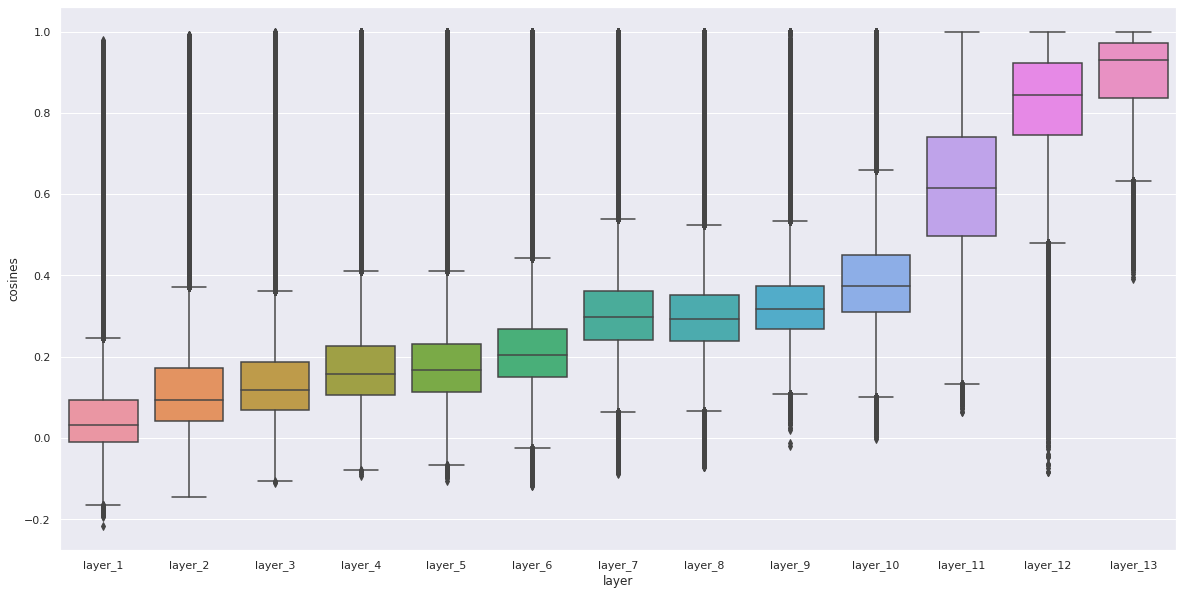

In [14]:

figure = plt.figure(figsize = (20,10))
# work on flaubert
df_dist , df_var = construct_df_dist(test_dataset_flaubert)
cos_values = df_cos(df_dist)
fig = sns.boxplot(x="layer" , y = "cosines",data = cos_values)

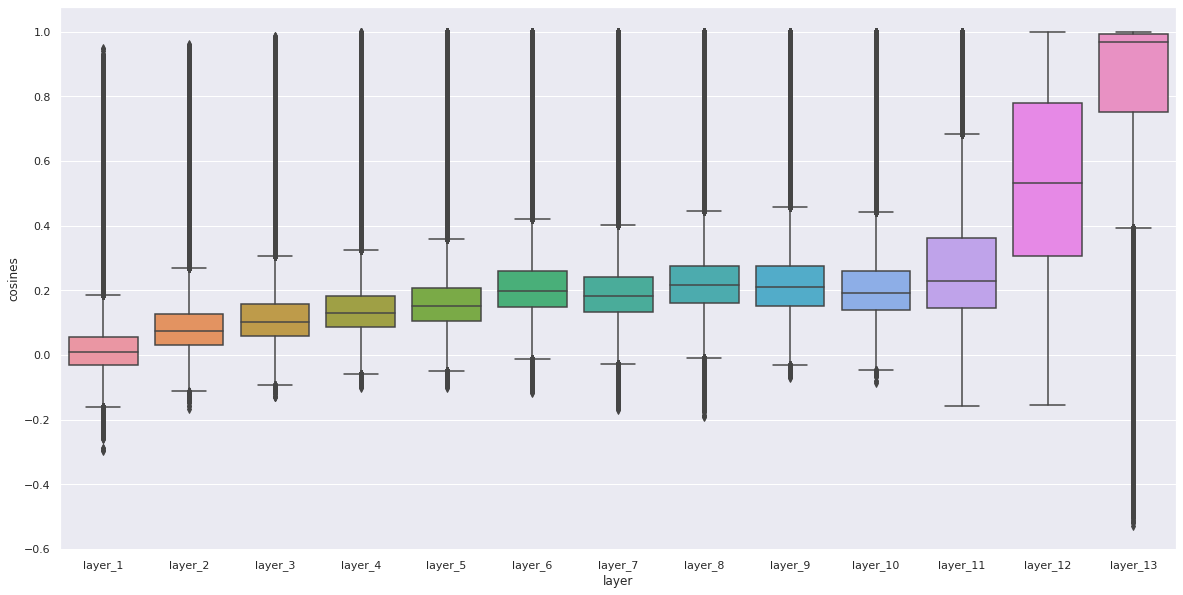

In [15]:
# work on camembert
df_dist , df_var = construct_df_dist(test_dataset_camembert , type_model="camembert")
cos_values = df_cos(df_dist)
figure = plt.figure(figsize = (20,10))
fig = sns.boxplot(x="layer" , y = "cosines",data = cos_values)

# Vcov study

In [16]:
def cov_emb (layer , attention_mask):
    '''
    input : layer --> torch tensor
            attention_mask --> an array of 0,1 (logical mask)
    '''
       
    nb_tok = layer.shape[1]
    
    l = []
    
    for i in range(nb_tok) :
        if attention_mask[i]==1 :
            l.append(list(layer[0,i,:].detach().numpy()))
        else :
            # if we encounter a padding all the rest is padding
            break
    
    l = np.array(l).T
    
    return(np.cov(l))

In [17]:
# construction of the dataframe for the boxplot of the trace

def df_trace_vcov(dataset , type_model = "flaubert" , nb_layer = 13) :

    legend_vect = []
    trace_vect = []

    for data in dataset :
        output = None
        
        # output of the model
        if type_model == "flaubert" :
            output = model_flaubert(attention_mask = torch.tensor([data["attention_mask"]]),
                        input_ids = torch.tensor([data["input_ids"]])
                       )
        else :
            output = model_camembert(attention_mask = torch.tensor([data["attention_mask"]]), 
                                     input_ids = torch.tensor([data["input_ids"]]))

        # hidden_states of the transformers
        hidden_states = output.hidden_states

        for i in range(nb_layer) :
            curr_layer = hidden_states[i]
            lay = "layer_"+str(i+1)
            buff = np.trace(cov_emb(curr_layer , data["attention_mask"]))
            legend_vect.append(lay)
            trace_vect.append(buff)

    df = pd.DataFrame({"layer":legend_vect,
                        "trace" : trace_vect})

    return df
        

In [18]:
test_dataset_camembert = tokenized_datasets_camembert["test"].select(range(100))
test_dataset_flaubert = tokenized_datasets_flaubert["test"].select(range(100))

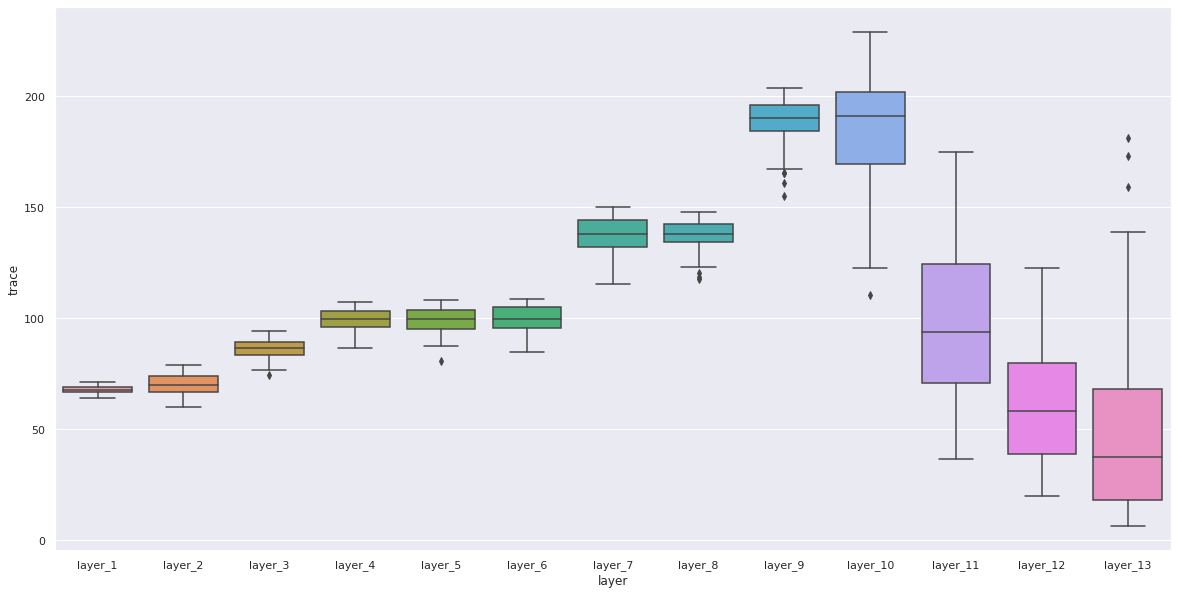

In [19]:
# work on flaubert
figure = plt.figure(figsize = (20,10))
df = df_trace_vcov(test_dataset_flaubert)
fig = sns.boxplot(x="layer" , y = "trace", data = df)

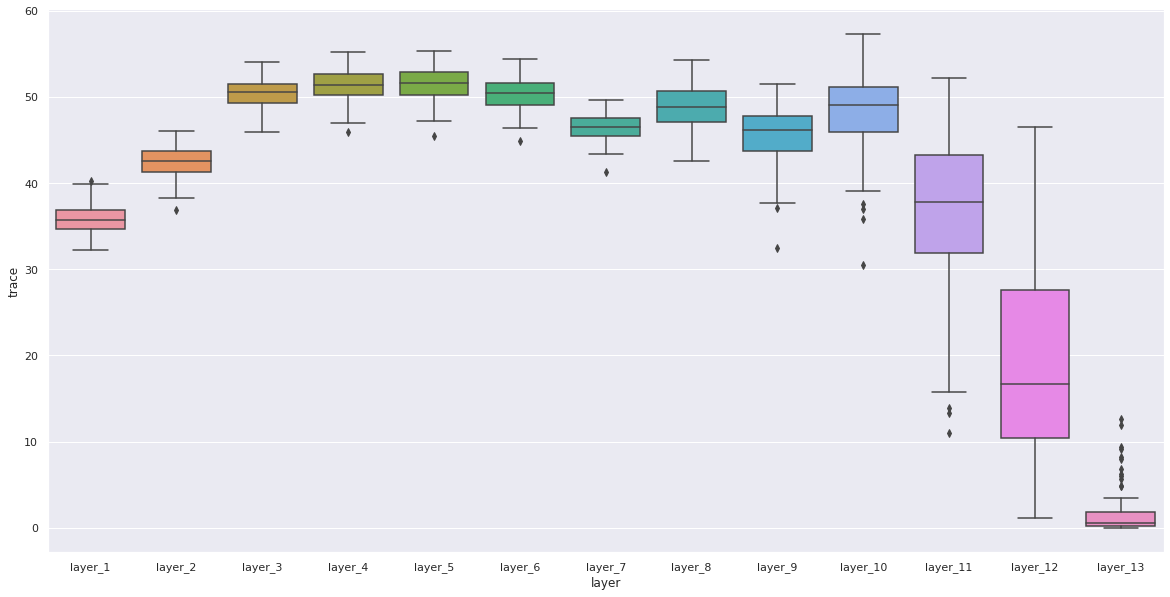

In [20]:
# work on camembert
figure = plt.figure(figsize = (20,10))
df = df_trace_vcov(test_dataset_camembert , type_model="camembert")
fig = sns.boxplot(x="layer" , y = "trace",data = df)

# Erank study

In [7]:
def erank_metric(W) :
    #   --> we assume that nrow(W) > ncol(W)
    #   --> decomposition of the matrix in singular value
    u, s, vh = np.linalg.svd(W, full_matrices=True)
    #   s --> singular values of the matrix W
    
    s1 = np.sum(s)      # sum of the singular values

    k = s/s1
    k = k*np.log(k)
    
    return(np.exp(-sum(k)))

In [8]:
def calculus_erank(dataset , type_model = "flaubert" , nb_tok = 512) :
    
    layer_W  = {}

    for i in range(13):
        layer_W[i+1] = []

    for data in dataset :
        output = None
        
        # output of the model
        if type_model == "flaubert" :
            output = model_flaubert(attention_mask = torch.tensor([data["attention_mask"]]),
                        input_ids = torch.tensor([data["input_ids"]])
                       )
        else :
            output = model_camembert(attention_mask = torch.tensor([data["attention_mask"]]), 
                                     input_ids = torch.tensor([data["input_ids"]]))

        # hidden_states of the transformers
        hidden_states = output.hidden_states

        for i in range(13):
            curr_layer = hidden_states[i][0]   #   --> current layer.

            for t in range(nb_tok) :
                if data["attention_mask"][t] == 1:
                    emb_tok = list(curr_layer[t,:].detach().numpy())
                    layer_W[i+1].append(emb_tok)
                else :
                    break

    d = {"erank" : [] , "layer" : []}
    for i in range(13):
        d["erank"].append(erank_metric(np.array(layer_W[i+1])))
        d["layer"].append("layer_"+str(i+1))

    return pd.DataFrame(d)

In [9]:
test_dataset_camembert = tokenized_datasets_camembert["test"].select(range(10))
test_dataset_flaubert = tokenized_datasets_flaubert["test"].select(range(10))

<AxesSubplot:xlabel='layer', ylabel='erank'>

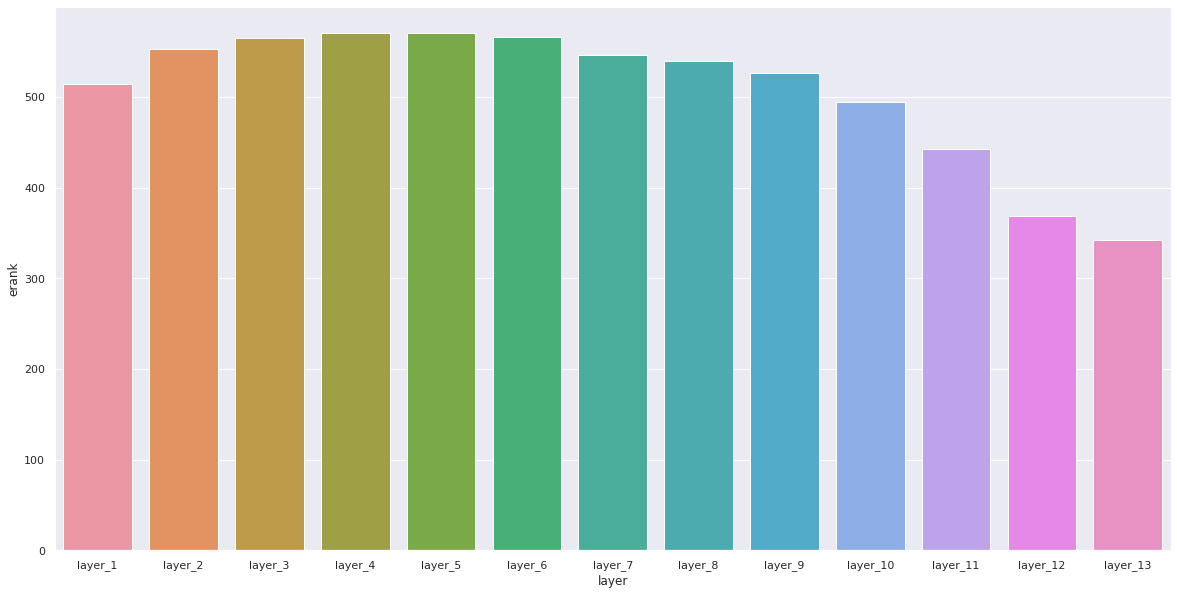

In [18]:
figure = plt.figure(figsize = (20,10))
df = calculus_erank(dataset = test_dataset_flaubert , type_model="flaubert")
sns.barplot(x = "layer" , y = "erank" , data = df)

In [19]:
df

,erank,layer
0,513.872805,layer_1
1,552.839510,layer_2
2,564.556831,layer_3
3,570.800282,layer_4
4,570.178681,layer_5
5,565.669307,layer_6
6,545.703501,layer_7
7,539.720193,layer_8
8,525.921995,layer_9
9,494.119366,layer_10


<AxesSubplot:xlabel='layer', ylabel='erank'>

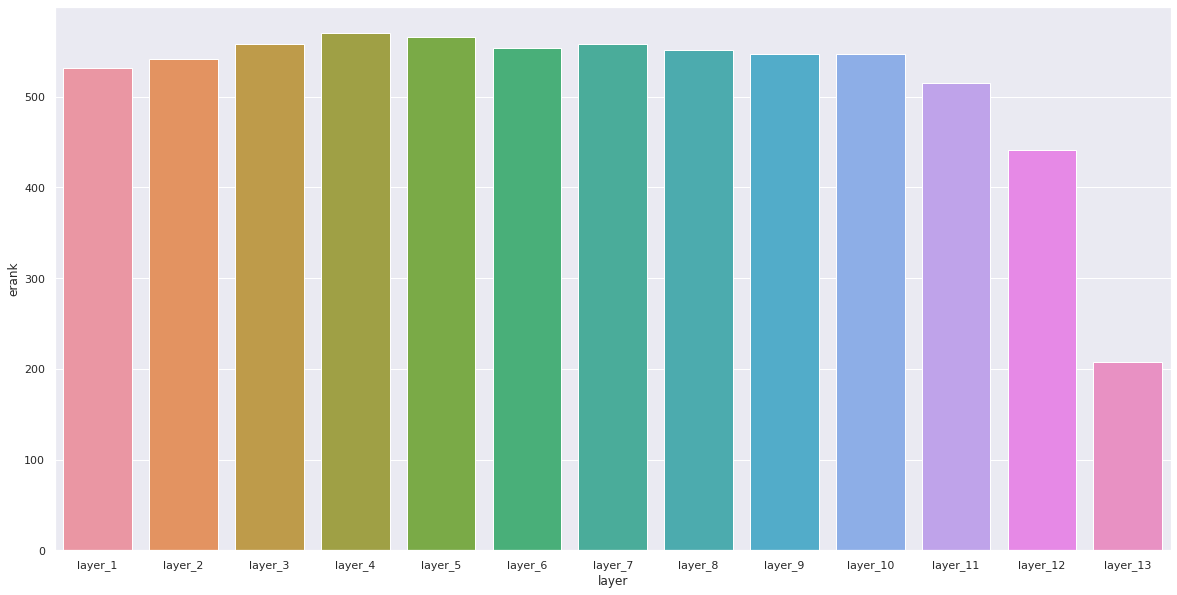

In [20]:
df = calculus_erank(dataset = test_dataset_camembert , type_model="camembert")
figure = plt.figure(figsize = (20,10))
sns.barplot(x = "layer" , y = "erank" , data = df)

In [21]:
df

,erank,layer
0,531.378063,layer_1
1,541.133562,layer_2
2,557.894326,layer_3
3,570.570455,layer_4
4,566.187766,layer_5
5,554.198884,layer_6
6,557.800987,layer_7
7,551.304196,layer_8
8,547.610044,layer_9
9,547.600742,layer_10
